<a href="https://colab.research.google.com/github/leandroaguazaco/data_science_portfolio/blob/main/Projects/04-Churn_Telco_Analysis/04_Churn_Telco_Analysis_03_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 align="center"> 4 - CHURN TELCO ANALYSIS </h1>

<div align="center">

  <img alt="Static Badge" src="https://img.shields.io/badge/active_project-true-blue">

</div>  

<h2 align="center"> 4.3 - Modeling </h2>

<div align="center">

  <img alt="Static Badge" src="https://img.shields.io/badge/active_section-true-blue">

  <img alt="Static Badge" src="https://img.shields.io/badge/section_status-in progress-green">

</div>  

<object
data="https://img.shields.io/badge/contact-Felipe_Leandro_Aguazaco-blue?style=flat&link=https%3A%2F%2Fwww.linkedin.com%2Fin%2Ffelipe-leandro-aguazaco%2F">
</object>

## a. Project summary

The aim of this project is to analyze and predict customer churn in the telco industry. The information pertains to client behavior, including in-call, out-call, and internet service consumption. There is a variable called 'Churn' that determines whether a customer churned within two weeks after canceling services. The information summarizes eight weeks of data for each telco line or client.

<h3 align="center"> <font color='orange'>NOTE: The project is distributed across multiple sections, separated into notebook files, in the following way:</font> </h3>



4.1 - Preprocessig data: load, join and clean data, and Exploratory data analysis, EDA.

4.2 - Premodeling: predict customer churn based on PyCaret library.

> <font color='gray'>  4.3 - Modeling: predict customer churn based on sklearn pipelines. </font> ✍ ▶ <font color='orange'> Current section </font>

4.4 - Analyzing and explaining predictions.

4.5 - Detecting vulneabilities in final machine learnig model.

4.6 - Model deployment with Streamlit.

## b. Install libraries

In [1]:
%%capture
!pip install polars
!pip install pyjanitor # Clean DataFrame
!pip install colorama
!pip install adjustText
!pip install scikit-optimize # BayesSearchCV
!pip install -U imbalanced-learn
!pip install umap-learn # Dimension reduction
!pip install mlflow
!pip install pyngrok
!pip install xgboost
!pip install lightgbm
!pip install catboost

## c. Import libraries

In [2]:
%%capture
# c.1 Python Utilies
import pandas as pd
import polars as pl
import numpy as np
import math
import warnings
from scipy.stats import spearmanr
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy.stats as stats
from janitor import clean_names, remove_empty
from colorama import Fore, Style
import rpy2
import shutil
import os
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
%%capture
# c.2 Machine learning with sklearn

import mlflow
from pyngrok import ngrok
import xgboost as xgb
import lightgbm as lgb
import catboost as catb

  ## Sklearn
    ### Imputation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
    ### Preporcessing
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder, RobustScaler, PowerTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
    ### Models
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import BayesianRidge, LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif # Univariate feature selection
from umap import UMAP # Dimensionallity reduction and feature selection
    ### Pipeline cache
from shutil import rmtree
from tempfile import mkdtemp
from joblib import Memory
    ### Imbalance data
from imblearn.combine import SMOTEENN, SMOTETomek # Combination of over- and under-sampling
from imblearn.over_sampling import SMOTE, SMOTENC # Synthetic Minority Over-sampling Technique
from imblearn.under_sampling import EditedNearestNeighbours # Undersampling
from imblearn.pipeline import make_pipeline as imb_make_pipeline
from imblearn.pipeline import Pipeline as imb_Pipeline
from sklearn.utils.class_weight import compute_class_weight
    ### Metrics for classification
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, RocCurveDisplay
from sklearn.metrics import accuracy_score, precision_score, balanced_accuracy_score, recall_score, f1_score, jaccard_score ## Higher better
from sklearn.metrics import roc_auc_score, matthews_corrcoef, cohen_kappa_score
    ### Cross validation and Hyperparameter tuning
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
# from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import KFold, RepeatedKFold, StratifiedKFold , RepeatedStratifiedKFold, ShuffleSplit, StratifiedShuffleSplit
from sklearn.model_selection import cross_validate, cross_val_score, cross_val_predict

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
# c.3 Setups
%matplotlib inline
plt.style.use("ggplot")
warnings.simplefilter("ignore")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## d. Custom functions

### d.1 - Type conversions

In [5]:
# d.1 dtypes conversion and memory reduce function.
def dtype_conversion(df: pd.DataFrame = None, verbose: bool = True)-> pd.DataFrame:
    """
    Summary:
      Function to dtypes conversion and save reduce memory usage; takes a DataFrame as argument, returns DataFrame.
      For more details, visit: https://towardsdatascience.com/how-to-work-with-million-row-datasets-like-a-pro-76fb5c381cdd.
      The modifications include type casting for numerical and object variables.
    Parameters:
      df (pandas.DataFrame): DataFrame containing information.
      verbose (bool, default = True): If true, display results (conversions and warnings)
    Returns:
      pandas.DataFrame: original DataFrame with dtypes conversions
      Plot original dtypes status, variable warning due high cardinality, save memory usage, final dtypes status.
    """
    # 0- Original dtypes
    # print(Fore.GREEN + "Input dtypes" + Style.RESET_ALL)
    # print(df.dtypes)
    # print("\n")
    print(Fore.RED + "Higha Cardinality, categorical features with levels > 15" + Style.RESET_ALL)

    # 1- Original memory_usage in MB
    start_mem = df.memory_usage().sum() / 1024 ** 2

    # 2- Numerical Types
    numerics = ["int8", "int16", "int32", "int64", "float16", "float32", "float64"]
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int": # First 3 characters
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if (c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max):
                    df[col] = df[col].astype(np.float32)
                #elif (c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max):
                #    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    # 3- Categorical Types
    high_card_vars = 0
    for col in df.select_dtypes(exclude = ["int8", "int16", "int32", "int64", "float16", "float32", "float64", "datetime64[ns]"]):
        categories = list(df[col].unique())
        cat_len = len(categories)
        if cat_len >= 2 and cat_len < 15:
           df[col] = df[col].astype("category")
        else:
          high_card_vars =+ 1
          # Print hight cardinality variables, amount of levels and a sample of 50 firts categories
          print(f"Look at: {Fore.RED + col + Style.RESET_ALL}, {cat_len} levels = {categories[:50]}")
    if high_card_vars == 0:
      print(Fore.GREEN + "None" + Style.RESET_ALL)
    else:
      pass

    # 4- Final memory_usage in MB
    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print("\n")
        print(f"{Fore.RED}Initial memory usage: {start_mem:.2f} MB{Style.RESET_ALL}")
        print(f"{Fore.BLUE}Memory usage decreased to {end_mem:.2f} MB ({ 100 * (start_mem - end_mem) / start_mem:.1f}% reduction){Style.RESET_ALL}")
        #print("\n")
        #print(Fore.GREEN + "Output dtypes" + Style.RESET_ALL)
        #print(df.dtypes)
        print("\n")

    # 5. Feature types
    print(Fore.GREEN + "Variable types" + Style.RESET_ALL)
    numerical_vars = len(df.select_dtypes(include = ["number"]).columns)
    categorical_vars = len(df.select_dtypes(include = ["category", "object"]).columns)
    datetime_vars = len(df.select_dtypes(include = ["datetime64[ns]"]).columns)
    print(f"Numerical Features: {numerical_vars}")
    print(f"Categorical Features: {categorical_vars}")
    print(f"Datetime Features: {datetime_vars}")

    return df

### d.2 - Multicollinearity remove class

In [6]:
class RemoveMulticollinearity(BaseEstimator, TransformerMixin):
  """
  Summary:
  Class to create a sklearn custom transformer. Features with the VIF (variance inflation factor)
  higher than 10 are removed, it removes all except the feature with the highest correlation to y or target.
  Calculation based on training dataset.
  Note:
    This transformer always should be applied after categorical encoding, such as one-hot encoding.
  """
  def __init__(self, threshold: int = 5, method: str = 'spearmanr'):
    """
    Attributes:
        threshold (str, 10): Variance inflation factor threshold.
        method (str, default = spearmanr): Correlation method.
        feature_indices_ (np.array, default = None): Features indices to retain
    """
    self.threshold = threshold
    self.method = method
    self.feature_indices_ = None
    self.features_remove_ = None

  def fit(self, X: np.array = None, y: np.array = None):
    """
    Parameters:
      X_train (np.array, efault = None): Dataset of transformed predictors.
      y_train (np.array, default = None): Dataset of transformed target.

    Return:
      None.
    """
    # 1. Input features indeces; converting target to numpy array.
    self.feature_indices_ = np.arange(X.shape[1])
    y_train_array = y_train.to_numpy()

    # 2. VIF calculation
    vif = np.array([variance_inflation_factor(X, i) for i in range(X.shape[1])])

    # 3. Correlation between target and predictors
    corr_y = np.array([abs(spearmanr(X[:, i], y_train_array)[0].round(3)) for i in range(X.shape[1])])

    # 4. Colum stack: features, vif and correlation
    final = np.column_stack((self.feature_indices_, vif, corr_y)).round(3)

    # 5. Aplying filter VIF <= 10, exclude highest correlation to y or target
    mask = np.where((final[:, 1] > 10) & (final[:, 2] != final[:, 2].max()), final[:, 0], -1) > 0
    self.feature_indices_ = self.feature_indices_[~mask]
    return self

  def transform(self, X):
    """
    Return:
      numpy array with multicollinearity features removed.
    """
    return X[:, self.feature_indices_]

### d.3 - Metrics for evaluation model

In [7]:
# d.3 Metrics for evaluation model - binary calification
def binary_classification_metrics(y_true, y_pred, average: str = "binary", pos_label: str | int = None) -> pd.DataFrame:
  """
  Summary:
    Function to calculate multiple metrics to assess the performance of classification models on unseen data.
    Requiered import pandas and sklearn metrics module.
  Parameters:
    y_true (array, pd.DataFrame): original target dataset.
    y_pred (array, pd.DataFrame): predicted target dataset.
    average (str, default = binary): type of averaging performed on the data, important for multiclass classification.
    pos_label (str|int, default = None): positive class in binary classification.
  Returns:
    DataFrame contains metrics of classificatioin performance.
  """
  # Calculate specificity and Negative Predictive Value for binary classification problems
  tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

  specificity = tn / (tn + fp)
  npv = tn / (tn + fn) # Negative Predictive Value

  # Metrics to evaluate:
  metrics_labels = ["Accuracy", "Precision", "Recall", "Specificity", "Negative Predictive Value", "F1-Score", "Balance Accuracy", "Jaccard-Score", "Matthews Corr Coef", "Cohen’s kappa"]

  # Average parameter
  average = average # "binary" for binary classfication, "micro, macro, ..." form multiclass classification

  # Calculations
  metrics_values = [accuracy_score(y_true, y_pred),
                    precision_score(y_true, y_pred, average = average, pos_label = pos_label),
                    recall_score(y_true, y_pred, average = average, pos_label = pos_label),
                    specificity,
                    npv,
                    f1_score(y_true, y_pred, average = average, pos_label = pos_label),
                    balanced_accuracy_score(y_true, y_pred),
                    jaccard_score(y_true, y_pred, average = average, pos_label = pos_label),
                    matthews_corrcoef(y_true, y_pred),
                    cohen_kappa_score(y1 = y_true, y2 = y_pred)]

  metrics_df = pd.DataFrame(data = {"Metric": metrics_labels,
                                    "Value": metrics_values})

  return metrics_df.round(3)

## 1 - Load data

In [8]:
# 1.1 - Import manin file from Google drive

# Mount Google Drive
drive.mount('/content/drive')


# Specify the source path in Google Drive
drive_filepath = '/content/drive/MyDrive/DataScience_Portfolio/04-Churn_Telco_Analysis/'

# Specify the destination path in Colab
colab_filepath = '/content/'

# Copy the file from Google Drive to Colab
try:
  shutil.copy(src = drive_filepath + '/churn_data.txt', dst = colab_filepath + '/churn_data.txt')
except:
  pass

Mounted at /content/drive


In [9]:
%%time
# 1.2 - Load data
#.drop_nulls() \
churn_df = pl.read_csv(source = 'churn_data.txt',
                       has_header = True,
                       separator = "|",
                       try_parse_dates = True,
                       encoding = "utf8") \
             .drop(columns = ["SUBSCRIBER_ID"]) \
             .drop_nulls(subset = ['churn']) \
             .with_columns(pl.col(['region', 'churn', 'canal', 'bandas', 'tipo_gross_adds']).cast(pl.Categorical)) \
             .to_pandas() \
             .pipe(dtype_conversion)

Higha Cardinality, categorical features with levels > 15
Look at: region, 34 levels = ['Bogota D.C.', 'Santander', 'Antioquia', nan, 'Cundinamarca', 'Quindio', 'Valle Del Cauca', 'Arauca', 'Bolivar', 'Atlantico', 'Tolima', 'Huila', 'Meta', 'Putumayo', 'Boyaca', 'Caldas', 'Cordoba', 'Nariño', 'Magdalena', 'Risaralda', 'Cauca', 'La Guajira', 'Norte De Santander', 'Caqueta', 'Cesar', 'Guaviare', 'Sucre', 'Amazonas', 'Guainia', 'Vichada', 'Choco', 'Casanare', 'Providencia Islas', 'Vaupes']


Initial memory usage: 175.54 MB
Memory usage decreased to 87.48 MB (50.2% reduction)


Variable types
Numerical Features: 38
Categorical Features: 5
Datetime Features: 0
CPU times: user 3.56 s, sys: 1.86 s, total: 5.42 s
Wall time: 5.24 s


In [10]:
churn_df.head()

,cant_sem_datos,prom_gb_tt,prom_gb_ran,prom_%_propia,continuidad_traf,variacion_datos_8s,cons_ult_sem,contrafico,mean_minutos_voz_in,mean_llamadas_in,...,bandas,tipo_gross_adds,semanas_antiguedad,semanas_contactos_pqr,contactos_ult_semana_pqr,seg_llamadas_ofertas_ult_semana,var_seg_llamadas_ofertas_4_semanas,porc_descuento_activo,jineteo,churn
0,1.0,0.603,0.000,1.000,1.000,0.000000,0.603,1,29.511000,5.571,...,Fdd Band 28,Gross Adds Migracion,1.0,1.0,2.0,0.0,0.0,0.0,1.0,No
1,5.0,3.369,0.075,0.975,1.250,-17.405001,2.783,1,52.870998,18.875,...,Ninguna,Gross Adds Nueva,4.0,0.0,0.0,0.0,0.0,0.0,1.0,No
2,8.0,0.832,0.019,0.983,0.500,-48.924999,0.425,1,64.025002,18.875,...,Ninguna,Gross Adds Migracion,16.0,0.0,0.0,0.0,0.0,0.0,1.0,No
3,8.0,6.824,0.328,0.933,0.727,-60.625000,2.687,1,148.910004,37.000,...,Fdd Band 28,Gross Adds Portacion,11.0,0.0,0.0,0.0,0.0,0.0,1.0,No
4,8.0,0.917,0.192,0.810,0.444,65.065002,1.514,1,77.785004,15.500,...,Fdd Band 28,Gross Adds Portacion,18.0,0.0,0.0,0.0,0.0,0.0,1.0,No


## 2 - Churn prediction: Machine Learning

### 2.1 - MLflow UI Setup

In [ ]:
# 1. Set the tracking URI to the default local file system
mlflow.set_tracking_uri('file:/content/mlruns')

In [ ]:
# 2. Set an experiment name and autolog
mlflow.set_experiment("04-Churn_Telco_Analysis")
mlflow.autolog(log_input_examples = True, log_model_signatures = True)

2023/07/30 04:41:17 INFO mlflow.tracking.fluent: Autologging successfully enabled for lightgbm.
2023/07/30 04:41:17 INFO mlflow.tracking.fluent: Autologging successfully enabled for tensorflow.
2023/07/30 04:41:17 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2023/07/30 04:41:17 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2023/07/30 04:41:17 INFO mlflow.tracking.fluent: Autologging successfully enabled for xgboost.


### 2.2 - Variables types

In [14]:
# Variables types

# Target feature
target_var = ["churn"]

# Datetime features
datetime_vars = churn_df.select_dtypes(include = "datetime64[ns]").columns.tolist()

# Numerical features
numerical_vars = churn_df.select_dtypes(include = "number").columns.tolist()

# Categorical features
nominal_vars = churn_df.select_dtypes(include = "category").columns.tolist()
nominal_vars.pop(-1) # Exclude target variable, instantiated above

# 2.2 Reorder DataFrame
new_col_order = target_var + numerical_vars + nominal_vars
churn_df = churn_df.reindex(columns = new_col_order)

In [15]:
len(churn_df.columns)

43

### 2.3 - Train - Test split

In [16]:
# Target and independent variables
X = churn_df.copy(deep = True).drop(labels = ["churn"], axis = 1)
y = churn_df.copy(deep = True).loc[:, "churn"]

In [17]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size = 0.80,
                                                    test_size = 0.20,
                                                    stratify = y,
                                                    random_state = 123456)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(476530, 42) (119133, 42) (476530,) (119133,)


### 2.4 - Pipeline Cache

#### Import pipeline cache files

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

# Specify the source path in Google Drive
drive_folderpath_cache = '/content/drive/MyDrive/DataScience_Portfolio/04-Churn_Telco_Analysis/'

# Specify the destination path in Colab
colab_folderpath_cache = '/content/'

# Copy the folder from Google Drive to Colab
try:
  shutil.copytree(drive_folderpath_cache + '/cachedir', colab_folderpath_cache + '/cachedir', dirs_exist_ok = True)
except:
  pass

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Export pipeline cache files

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

# Specify the temporary file or folder path in Colab
temp_folderpath_cache = '/content/cachedir'

# Specify the destination path in Google Drive
drive_folderpath_cache = '/content/drive/MyDrive/DataScience_Portfolio/04-Churn_Telco_Analysis/cachedir'

# Remove the existing folder in Google Drive
try:
  shutil.rmtree(drive_folderpath_cache)
except:
  pass

# Copy the temporary folder to Google Drive
shutil.copytree(temp_folderpath_cache, drive_folderpath_cache, dirs_exist_ok = True)

#### Create memory folder

In [ ]:
# Create a temporary folder to store the transformers of the pipeline
memory = Memory(location = "cachedir", verbose = 1)

In [ ]:
# Remove the cache directory at the end of your script
# Don't run
rmtree("cachedir")

### 2.5 - Encoding target variable

In [38]:
# 1. Instantiate Encoder
target_encoder = LabelEncoder()

# 2. y train encoder
y_train_encoded = target_encoder.fit_transform(y_train)
print(target_encoder.classes_)
y_train = pd.DataFrame(data = y_train_encoded, columns = ["churn"])
print(y_train.head())

# 3.3 y test encoder
y_test_encoded = target_encoder.transform(y_test)
y_test = pd.DataFrame(data = y_test_encoded, columns = ['churn'])
print(y_test.head())

['No' 'Sí']
   churn
0      0
1      0
2      0
3      0
4      1
   churn
0      0
1      0
2      0
3      0
4      0


### 2.6 - Numerical Pipeline

In [ ]:
# In this case, don't required

### 2.7 - Ordinal Pipeline

In [ ]:
# In this case, don't required

### 2.8 - Nominal Pipeline

In [18]:
# Nominal pipeline: one-hot-encoding

nominal_pipeline = make_pipeline(
    # 1. Nominal encoder
    OneHotEncoder(categories = "auto",
                  drop = "first", # "first" or "None", Specifies a methodology to use to drop one of the categories per feature
                  sparse_output = False,
                  dtype = "float", # Desired dtype of output
                  handle_unknown = 'infrequent_if_exist',
                  min_frequency = 0.03,
                  max_categories = 30),
)

nominal_pipeline

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(drop='first', dtype='float',
                               handle_unknown='infrequent_if_exist',
                               max_categories=30, min_frequency=0.03,
                               sparse_output=False))])

### 2.9 - Transformers

In [ ]:
# 1 Combine ordinal and nominal pipelines
transformations = ColumnTransformer(
    transformers=[("numerical", "passthrough", numerical_vars), # No transformation required for numerical variables
                  # ("ordinal", ordinal_pipeline, ordinal_vars), # No ordinal data
                  ("nominal", nominal_pipeline, nominal_vars)],
    #remainder = 'passthrough'
)

### 2.10 - Full pipeline

#### Imbalance sampling methods

##### Class imbalance ratio

In [ ]:
# Calculate the class imbalance ratio based on  XGBoostClassifier
# https://xgboost.readthedocs.io/en/stable/tutorials/param_tuning.html
positive_samples = sum(y_train.loc[:, 'churn'] == 1)
negative_samples = sum(y_train.loc[:, 'churn'] == 0)
imbalance_ratio = (negative_samples / positive_samples)

##### Oversampling - SMOTE

In [ ]:
# As part of the experimentation cycle, in section 1 - Load data, dropnas operation is applied to the entire dataset
# Synthetic Minority Over-sampling Technique for Nominal and Continuous
smotenc = SMOTENC(categorical_features = nominal_vars, sampling_strategy = 'auto', random_state = 123456)
X_train_over, y_train_over = smotenc.fit_resample(X_train, y_train)

y_train_over.value_counts()

# SMOTE(sampling_strategy = 'auto', random_state = 123456) # Only numerical data
#X_train_deep_over, y_train_deep_over = smote.fit_resample(X_train_deep, y_train)

##### Undersampling - ENN

In [101]:
# Undersample based on the edited nearest neighbour method.
# This method will clean the database by removing samples close to the decision boundary.
# Only numerical data.
enn = EditedNearestNeighbours()
X_train_deep_under, y_train_deep_under = enn.fit_resample(X_train_deep, y_train)

print(X_train_deep_under.shape, y_train_deep_under.shape)

(436646, 55) (436646, 1)


In [102]:
y_train_deep_under.value_counts()

churn
0        420854
1         15792
dtype: int64

##### Over-under-sampling - SMOTEENN

In [109]:
# Over-sampling using SMOTE and cleaning using ENN.
# Combine over- and under-sampling using SMOTE and Edited Nearest Neighbours.
# Only numerical data.
sme = SMOTEENN(random_state = 123456)
X_train_comb, y_train_comb = sme.fit_resample(X_train_deep, y_train)

print(X_train_comb.shape, X_train_comb.shape)
y_train_comb.value_counts()

churn
1        460553
0        342155
dtype: int64

##### Imbalanced learn pipeline

Pipeline constructor to apply under-sampling ENN and combine over-under-sampling SMOTEENN.

In [ ]:
# Imbalance learn pipelien


# a) Nominal pipeline
nominal_pipeline = make_pipeline(
    # 1. Nominal encoder
    OneHotEncoder(categories = "auto",
                  drop = "first", # "first" or "None", Specifies a methodology to use to drop one of the categories per feature
                  sparse_output = False,
                  dtype = "float", # Desired dtype of output
                  handle_unknown = 'infrequent_if_exist',
                  min_frequency = 0.03,
                  max_categories = 30)
)

# b) Ordinal pipeline
"""
ordinal_pipeline = make_pipeline(
    # 1. Ordinal encoder, if neccesary more steps, aggregate them inside pipeline
    OrdinalEncoder(categories = [["Entre 2 meses y 6 meses", "Entre 7 meses y 1 año", "Entre 1 y 2 años", "Más de 2 años"],
                                 ["De 18 a 25 años", "De 26 a 35 años", "De 36 a 45 años", "De 46 a 55 años", "De 56 a 65 años", "Más de 66"]],
                   dtype = 'float',
                   handle_unknown = 'use_encoded_value',
                   unknown_value = np.nan,
                   encoded_missing_value = np.nan),
)
"""

# c) Categorical transformations
transformations = ColumnTransformer(
    transformers=[("numerical", "passthrough", numerical_vars), # No transformation required for numerical variables
                  # ("ordinal", ordinal_pipeline, ordinal_vars), # No ordinal data
                  ("nominal", nominal_pipeline, nominal_vars)],
    #remainder = 'passthrough'
)


# d) Pipeline to use imbalanced learn function
sampling_pipeline = make_pipeline(
    # 1. Numerical and categorical (nominal + ordinal) transformers
    transformations,

    # 2. Impute missing values
    IterativeImputer(estimator = BayesianRidge(),
                     max_iter = 10,
                     random_state = 123456),

)

sampling_pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numerical', 'passthrough',
                                                  ['cant_sem_datos',
                                                   'prom_gb_tt', 'prom_gb_ran',
                                                   'prom_%_propia',
                                                   'continuidad_traf',
                                                   'variacion_datos_8s',
                                                   'cons_ult_sem', 'contrafico',
                                                   'mean_minutos_voz_in',
                                                   'mean_llamadas_in',
                                                   'mean_llamadas_in_num_dif',
                                                   'mean_porcent_llamadas_fallidas_in',
                                                   'mean_porcent_minutos...
                                                   'var_minutos_out_8sem',
                                                   'var_llamadas_out_8sem', ...]),
                                                 ('nominal',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 dtype='float',
                                                                                 handle_unknown='infrequent_if_exist',
                                                                                 max_categories=30,
                                                                                 min_frequency=0.03,
                                                                                 sparse_output=False))]),
                                                  ['canal', 'region', 'bandas',
                                                   'tipo_gross_adds'])])),
                ('iterativeimputer',
                 IterativeImputer(estimator=BayesianRidge(),
                                  random_state=123456))])

In [ ]:
X_train_under = sampling_pipeline.fit_transform(X_train)

#### Final Full pipeline

In [ ]:
# Full pipeline original

full_pipeline = make_pipeline(
    # 1. Numerical and categorical (nominal + ordinal) transformers
    transformations,

    # 2. Impute missing values
    IterativeImputer(estimator = BayesianRidge(),
                     max_iter = 10,
                     random_state = 123456),

    # 3. Feature selector that removes all low-variance features
    VarianceThreshold(threshold = 0.1),

    # 4. Imbalance sampling

    # 5. Scale features
    RobustScaler(with_centering = True,
                 with_scaling = True,
                 quantile_range = (25.0, 75.0),
                 copy = True,
                 unit_variance = False),

    # 6. Transform features
    PowerTransformer(method = 'yeo-johnson',
                     standardize = True,
                     copy = True),

    # 7. Dimensionality reduction
    PCA(n_components = 'mle'),
    # UMAP(n_components = 5),

    # 8. Feature selection: univariate feature selection ~ 50% of features
    SelectKBest(score_func = f_classif, k = 20),

    # 9. Classifier
    lgb.LGBMClassifier(),

    # 10. Memory cache
    memory = memory
)

full_pipeline

Pipeline(memory=Memory(location=cachedir/joblib),
         steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numerical', 'passthrough',
                                                  ['cant_sem_datos',
                                                   'prom_gb_tt', 'prom_gb_ran',
                                                   'prom_%_propia',
                                                   'continuidad_traf',
                                                   'variacion_datos_8s',
                                                   'cons_ult_sem', 'contrafico',
                                                   'mean_minutos_voz_in',
                                                   'mean_llamadas_in',
                                                   'mean_llamadas_in_num_dif',
                                                   'mean_porcent_lla...
                                                  ['canal', 'region', 'bandas',
                                                   'tipo_gross_adds'])])),
                ('iterativeimputer',
                 IterativeImputer(estimator=BayesianRidge(),
                                  random_state=123456)),
                ('variancethreshold', VarianceThreshold(threshold=0.1)),
                ('robustscaler', RobustScaler()),
                ('powertransformer', PowerTransformer()),
                ('pca', PCA(n_components='mle')),
                ('selectkbest', SelectKBest(k=20)),
                ('lgbmclassifier', LGBMClassifier())])

In [ ]:
# Full pipeline with imb_Pipeline

full_pipeline = imb_Pipeline(
[
    # 1. Numerical and categorical (nominal + ordinal) transformers
    ('transformations', transformations),

    # 2. Impute missing values
    ('iterativeImputer', IterativeImputer(estimator = BayesianRidge(),
                                          max_iter = 10,
                                          random_state = 123456)),

    # 3. Feature selector that removes all low-variance features
    ('varianceThreshold', VarianceThreshold(threshold = 0.1)),

    # 4. Imbalance sampling
    ('enn', EditedNearestNeighbours()),

    # 5. Scale features
    ('robustScaler', RobustScaler(with_centering = True,
                                  with_scaling = True,
                                  quantile_range = (25.0, 75.0),
                                  copy = True,
                                  unit_variance = False)),

    # 6. Transform features
    ('powerTransformer' ,PowerTransformer(method = 'yeo-johnson',
                                          standardize = True,
                                          copy = True)),

    # 7. Dimensionality reduction
    ('pca', PCA(n_components = 'mle')),
    # UMAP(n_components = 5),

    # 8. Feature selection: univariate feature selection ~ 50% of features
    ('selectKBest', SelectKBest(score_func = f_classif, k = 20)),

    # 9. Classifier
    ('lightgbmclassifier', lgb.LGBMClassifier()),
],

    # 10. Memory cache
    memory = memory
)

full_pipeline

Pipeline(memory=Memory(location=cachedir/joblib),
         steps=[('transformations',
                 ColumnTransformer(transformers=[('numerical', 'passthrough',
                                                  ['cant_sem_datos',
                                                   'prom_gb_tt', 'prom_gb_ran',
                                                   'prom_%_propia',
                                                   'continuidad_traf',
                                                   'variacion_datos_8s',
                                                   'cons_ult_sem', 'contrafico',
                                                   'mean_minutos_voz_in',
                                                   'mean_llamadas_in',
                                                   'mean_llamadas_in_num_dif',
                                                   'mean_porcent_llama...
                ('iterativeImputer',
                 IterativeImputer(estimator=BayesianRidge(),
                                  random_state=123456)),
                ('varianceThreshold', VarianceThreshold(threshold=0.1)),
                ('enn', EditedNearestNeighbours()),
                ('robustScaler', RobustScaler()),
                ('powerTransformer', PowerTransformer()),
                ('pca', PCA(n_components='mle')),
                ('selectKBest', SelectKBest(k=20)),
                ('lightgbmclassifier', LGBMClassifier())])

### 2.11 - Estimators and imbalance ratio

#### XGBoost Classifier

In [ ]:
# 2. Estimator hyperparameters
full_pipeline.named_steps['xgbclassifier'].get_params()

In [ ]:
xgb.XGBClassifier(booster = "gbtree",
                  objective = "binary:logistic",
                  n_estimators = 100,
                  scale_pos_weight = imbalance_ratio)

In [ ]:
# Grid parameter if BayesSearchCV is used
xgb_param_bayes_space = {"selectkbest__k": Integer(low=10, high=43),
                         'pca__n_components': Real(low=0.4, high=0.95, prior="uniform"),
                         "xgbclassifier__max_depth": Integer(low=4, high=10),
                         "xgbclassifier__min_child_weight": Integer(low=0, high=10),
                         "xgbclassifier__subsample": Real(low=0.4, high=1.0, prior="uniform"),
                         "xgbclassifier__colsample_bytree": Real(low=0.4, high=1.0, prior="uniform"),
                         "xgbclassifier__n_estimators": Integer(low=100, high=1000),
                         "xgbclassifier__learning_rate": Real(low=0.01, high=0.3, prior="uniform"),
                         "xgbclassifier__gamma": Integer(low=0, high=1),
                         "xgbclassifier__reg_lambda": Integer(low=1, high=5),
                         "xgbclassifier__reg_alpha": Integer(low=0, high=5)}

#### LightGBM Classifier

In [ ]:
# 2. Estimator hyperparameters
full_pipeline.named_steps['lgbmclassifier'].get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'scale_pos_weight': 29.175413711583925}

In [ ]:
lgb.LGBMClassifier(scale_pos_weight = imbalance_ratio, # Like in XGBoostClassifier
                   early_stopping_round = 70),

(LGBMClassifier(early_stopping_round=70, scale_pos_weight=29.175413711583925),)

In [ ]:
# Grid parameter if BayesSearchCV is used
lgb_param_bayes_space = {"selectkbest__k": Integer(low=10, high=30),
                         #'pca__n_components': Real(low=0.4, high=0.95, prior="uniform"),
                         "lgbmclassifier__colsample_bytree": Real(low=0.4, high=1.0, prior="uniform"),
                         "lgbmclassifier__learning_rate": Real(low=0.01, high=0.3, prior="uniform"),
                         "lgbmclassifier__max_depth": Integer(low=4, high=12),
                         "lgbmclassifier__num_leaves": Integer(low=10, high=200),
                         "lgbmclassifier__min_child_samples":Integer(low=20, high=100),
                         "lgbmclassifier__min_child_weight": Real(low=0.0, high=0.3, prior="uniform"),
                         "lgbmclassifier__min_split_gain": Real(low=0.0, high=0.1, prior="uniform"),
                         "lgbmclassifier__n_estimators": Integer(low=100, high=1000),
                         "lgbmclassifier__reg_alpha": Real(low=0.0, high=1, prior="uniform"),
                         "lgbmclassifier__reg_lambda": Real(low=0.0, high=1, prior="uniform"),
                         "lgbmclassifier__subsample": Real(low=0.3, high=1.0, prior="uniform")}

#### CatBoost Classifier

In [ ]:
full_pipeline.named_steps['catboostclassifier'].get_params()

{'class_weights': [1, 29.175413711583925]}

In [ ]:
catb.CatBoostClassifier(class_weights = [1, imbalance_ratio])

In [ ]:
# Grid parameter if BayesSearchCV is used
cat_param_bayes_space = {"selectkbest__k": Integer(low=10, high=43),
                         'pca__n_components': Real(low=0.4, high=0.95, prior="uniform"),
                         "catboostclassifier__learning_rate": Real(low=0.01, high=0.3, prior="uniform"),
                         "catboostclassifier__depth": Integer(low=4, high=12),
                         "catboostclassifier__l2_leaf_reg": Integer(low=1, high=10),
                         "catboostclassifier__iterations": Integer(low=100, high=1000),
                         "catboostclassifier__random_strength": Real(low=0.1, high=1, prior="uniform"),
                         "catboostclassifier__bagging_temperature": Integer(low=1, high=6),
                         "catboostclassifier__leaf_estimation_method": Categorical(["Newton", None, 'Gradient', 'Exact']),
                         "catboostclassifier__min_data_in_leaf": Integer(low=20, high=50)}

#### AdaBoost Classifier

In [ ]:
full_pipeline.named_steps['adaboostclassifier'].get_params()

{'algorithm': 'SAMME.R',
 'base_estimator': 'deprecated',
 'estimator': None,
 'learning_rate': 1.0,
 'n_estimators': 50,
 'random_state': None}

In [ ]:
AdaBoostClassifier()

AdaBoostClassifier()

In [ ]:
ada_param_bayes_space = {"selectkbest__k": Integer(low=10, high=43),
                         'pca__n_components': Real(low=0.4, high=0.95, prior="uniform"),
                         "adaboostclassifier__learning_rate": Real(low=0.01, high=1, prior="uniform"),
                         "adaboostclassifier__n_estimators": Integer(low=50, high=200)}

#### Random ForestClassifier

In [ ]:
full_pipeline.named_steps['randomforestclassifier'].get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [ ]:
RandomForestClassifier(class_weight = 'balanced',
                       n_jobs = -1)

RandomForestClassifier(class_weight='balanced')

In [ ]:
rf_param_bayes_space = {"selectkbest__k": Integer(low=10, high=43),
                        'pca__n_components': Real(low=0.4, high=0.95, prior="uniform"),
                        "randomforestclassifier__n_estimators": Integer(low=100, high=1000),
                        "randomforestclassifier__max_depth": Integer(low=4, high=20),
                        "randomforestclassifier__min_samples_split": Integer(low=2, high=20),
                        "randomforestclassifier__min_samples_leaf": Integer(low=1, high=10),
                        "randomforestclassifier__class_weight": Categorical(["balanced", None]),
                        "randomforestclassifier__min_impurity_decrease": Real(low=0, high=0.5),
                        "randomforestclassifier__ccp_alpha": Real(low=0, high=0.15)}

#### Logistic Regression

In [ ]:
full_pipeline.named_steps['logisticregression'].get_params()

{'C': 1.0,
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': -1,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [ ]:
LogisticRegression(class_weight ='balanced',
                   n_jobs = -1)

LogisticRegression(class_weight='balanced', n_jobs=-1)

In [ ]:
lr_param_bayes_space = {"selectkbest__k": Integer(low=10, high=30),
                        #'pca__n_components': Real(low=0, high=1, prior="uniform"),
                        "logisticregression__C": Integer(low=1, high=100),
                        #"logisticregression__penalty": Categorical(["l1", "l2"]),
                        "logisticregression__tol":  Real(low=0.0001, high=0.02),
                        "logisticregression__max_iter": Integer(low=100, high=1000),
                        #"logisticregression__solver": Categorical(['lbfgs', 'sag', 'newton-cg', 'liblinear', 'saga', 'newton-cholesky']),
                        "logisticregression__l1_ratio": Real(low=0, high=1)}

### 2.12 - Hyperparameter Tuning

In [ ]:
# 0. Cross-validation: evaluating estimator performance
"""
https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-iterators
"""
# Cross-validation iterators for Independent and Identically Distributed (i.i.d.) data
# I will used alternative of cv iterators

# 5 k-fold cross validation
kf = KFold(n_splits = 5)

# Stratified folds: each set contains approximately the same percentage of samples of each target class as the complete set
skf = StratifiedKFold(n_splits = 5)

# Shuffle & Split: iterator will generate a user defined number of independent train / test dataset splits
ss = ShuffleSplit(n_splits = 5, test_size = 0.20, random_state = 123456)

# Stratified ShuffleSplit cross-validator
sss = StratifiedShuffleSplit(n_splits = 5, test_size= 0.2, random_state = 123456)

#### BayesSearchCV

First, hyperparameter tuning is performed locally. With the obtained results, an experiment is loaded into MLflow to track performance.

In [ ]:
# Bayesian optimization over hyperparameters
BayesSearchCV_pipeline = BayesSearchCV(estimator = full_pipeline,
                                           search_spaces = lgb_param_bayes_space,
                                           n_iter = 150,
                                           scoring = "recall",
                                           cv = sss,
                                           n_jobs = 1,
                                           refit = True,
                                           random_state = 123456,
                                           return_train_score = True)

In [ ]:
#Fit the model.
%%time
BayesSearchCV_pipeline.fit(X_train, y_train)

In [ ]:
# Cross validation results
BayesSearchCV_pipeline.cv_results_

# Best score
BayesSearchCV_pipeline.best_score_

In [ ]:
# Best parameters
BayesSearchCV_pipeline.best_params_

### 2.13 - Experimentation

In this section, using MLflow, I will to record and query experiments: code, data, config, and results.

#### Import mlruns from Google Drive

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

# Specify the source path in Google Drive
drive_folderpath_mlruns = '/content/drive/MyDrive/DataScience_Portfolio/04-Churn_Telco_Analysis/'

# Specify the destination path in Colab
colab_folder_path = '/content/'

# Copy the folder from Google Drive to Colab
try:
  shutil.copytree(drive_folderpath_mlruns + '/mlruns', colab_folder_path + '/mlruns', dirs_exist_ok = True)
except:
  pass

Mounted at /content/drive


#### Export mlruns to Google Drive

In [ ]:
# Specify the temporary file or folder path in Colab
temp_folderpath_mlruns = '/content/mlruns'

# Specify the destination path in Google Drive
drive_folderpath_mlruns = '/content/drive/MyDrive/DataScience_Portfolio/04-Churn_Telco_Analysis/mlruns'

# Remove the existing folder in Google Drive
try:
  shutil.rmtree(drive_folderpath_mlruns)
except:
  pass

# Copy the temporary folder to Google Drive
shutil.copytree(temp_folderpath_mlruns, drive_folderpath_mlruns, dirs_exist_ok = True)

'/content/drive/MyDrive/DataScience_Portfolio/04-Churn_Telco_Analysis/mlruns'

#### Experiments

In [ ]:
# 1 - Fit the model.
# Fit all the transformers one after the other and transform the data. Finally, fit the transformed data using the final estimator.

%%time
description = 'LightGBMClassifier without tuned hyperparameters, all pipeline steps and perform under-sampling using ENN.'
with mlflow.start_run(run_name = "12-LightGBMClassifier_not_tuned_ENN", description = description) as run:
  full_pipeline.fit(X_train, y_train)
  y_pred_raw = full_pipeline.predict(X_test)

  # Evaluation metrics
  y_prob_pred = full_pipeline.predict_proba(X_test)[:, 1]
  test_auc = roc_auc_score(y_true = y_test, y_score = y_prob_pred)
  tn, fp, fn, tp = confusion_matrix(y_test, y_pred_raw).ravel()
  test_specificity = tn / (tn + fp)
  test_npv = tn / (tn + fp) # Negative Predictive Value
  test_accuracy_score = accuracy_score(y_test, y_pred_raw)
  test_precision_score = precision_score(y_test, y_pred_raw)
  test_recall_score = recall_score(y_test, y_pred_raw)
  test_f1_score = f1_score(y_test, y_pred_raw)
  test_balanced_accuracy_score = balanced_accuracy_score(y_test, y_pred_raw)
  test_jaccard_score = jaccard_score(y_test, y_pred_raw)
  test_matthews_corrcoef = matthews_corrcoef(y_test, y_pred_raw)
  test_cohen_kappa_score = cohen_kappa_score(y1 = y_test, y2 = y_pred_raw)

  mlflow.log_metric('testing_accuracy_score', test_accuracy_score)
  mlflow.log_metric('testing_precision_score', test_precision_score)
  mlflow.log_metric('testing_recall_score', test_recall_score)
  mlflow.log_metric('testing_specificityt', test_specificity)
  mlflow.log_metric('testing_npv_X_test', test_npv)
  mlflow.log_metric('testing_f1_score', test_f1_score)
  mlflow.log_metric('testing_balanced_accuracy_score', test_balanced_accuracy_score)
  mlflow.log_metric('testing_jaccard_score', test_jaccard_score)
  mlflow.log_metric('testing_matthews_corrcoef', test_matthews_corrcoef)
  mlflow.log_metric('testing_cohen_kappa_score', test_cohen_kappa_score)
  mlflow.log_metric('testing_roc_auc', test_auc)

In [ ]:
# 2 - Open a secure tunnels from public MLflow URL to localhost:
ngrok.kill()
ngrok_tunnel = ngrok.connect(addr="5000", proto= "http", bind_tls = True)
ngrok.set_auth_token("2Siae72MMz4I2KtDOd9oxxV52gU_4UHBVTbE7bFnfYw4PDvuv")
print("MLflow Tracking UI: ", ngrok_tunnel.public_url)

# 3. View MLflow runs and experiments
!mlflow ui

MLflow Tracking UI:  https://60d2-34-23-72-32.ngrok-free.app
[2023-07-31 01:18:40 +0000] [7090] [INFO] Starting gunicorn 20.1.0
[2023-07-31 01:18:40 +0000] [7090] [INFO] Listening at: http://127.0.0.1:5000 (7090)
[2023-07-31 01:18:40 +0000] [7090] [INFO] Using worker: sync
[2023-07-31 01:18:40 +0000] [7095] [INFO] Booting worker with pid: 7095
[2023-07-31 01:18:40 +0000] [7096] [INFO] Booting worker with pid: 7096
[2023-07-31 01:18:40 +0000] [7097] [INFO] Booting worker with pid: 7097
[2023-07-31 01:18:40 +0000] [7098] [INFO] Booting worker with pid: 7098
[2023-07-31 01:19:57 +0000] [7090] [INFO] Handling signal: int

Aborted!
[2023-07-31 01:19:57 +0000] [7098] [INFO] Worker exiting (pid: 7098)
[2023-07-31 01:19:57 +0000] [7095] [INFO] Worker exiting (pid: 7095)
[2023-07-31 01:19:57 +0000] [7096] [INFO] Worker exiting (pid: 7096)
[2023-07-31 01:19:57 +0000] [7097] [INFO] Worker exiting (pid: 7097)
[2023-07-31 01:19:58 +0000] [7090] [INFO] Shutting down: Master


### 2.14 - Predictions

In [ ]:
# Transform the data, and apply predict with the final estimator.

# Call transform of each transformer in the pipeline.
# The transformed data are finally passed to the final estimator that calls predict method.
# Only valid if the final estimator implements predict.

# Raw Predictions
# target_encoder.inverse_transform to reverse label encoding, in this case not necessary.
y_test_pred_raw = pd.DataFrame(full_pipeline.predict(X_test),
                               columns = ["churn_pred"])

# Probability predictions
y_test_pred_prob = pd.DataFrame(full_pipeline.predict_proba(X_test), columns = ["0", "1"]).round(2)

# Original classification
#y_test_original = pd.DataFrame(target_encoder.inverse_transform(y_test),
#                               columns = ["target"])
y_test_original = y_test.reset_index(drop = True)

# Original predictors
X_test_original = X_test.reset_index(drop = True)

# Prediction
predictions = pd.concat([X_test_original,
                         y_test_original,
                         y_test_pred_raw,
                         y_test_pred_prob],
                         axis = 1)

print(predictions.head().to_markdown())

2023/07/30 05:08:40 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/07/30 05:08:42 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).


|    |   cant_sem_datos |   prom_gb_tt |   prom_gb_ran |   prom_%_propia |   continuidad_traf |   variacion_datos_8s |   cons_ult_sem |   contrafico |   mean_minutos_voz_in |   mean_llamadas_in |   mean_llamadas_in_num_dif |   mean_porcent_llamadas_fallidas_in |   mean_porcent_minutos_origen_wom |   mean_porcent_minutos_origen_otros |   var_minutos_in_4sem |   var_llamadas_in_4sem |   var_minutos_in_8sem |   var_llamadas_in_8sem |   mean_minutos_voz_out |   mean_llamadas_out |   mean_llamadas_out_num_dif |   mean_porcent_minutos_ran_out |   mean_porcent_minutos_volte_out |   mean_porcent_llamadas_fallidas_out |   mean_porcent_minutos_wom_out |   mean_porcent_minutos_otros_out |   var_minutos_out_4sem |   var_llamadas_out_4sem |   var_minutos_out_8sem |   var_llamadas_out_8sem |   lineas_cliente |   semanas_antiguedad |   semanas_contactos_pqr |   contactos_ult_semana_pqr |   seg_llamadas_ofertas_ult_semana |   var_seg_llamadas_ofertas_4_semanas |   porc_descuento_activo |   jineteo | c

### 2.15 - Evaluation Metrics

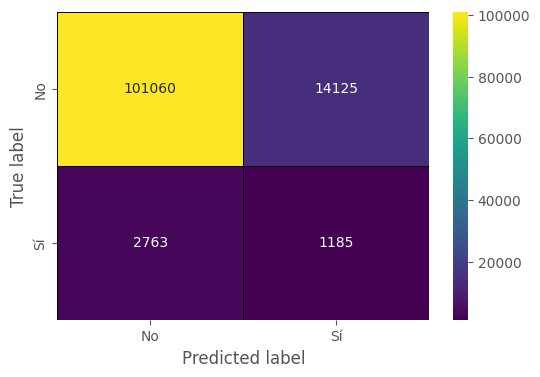

In [ ]:
cm = confusion_matrix(y_true = y_test_original,
                      y_pred = y_test_pred_raw,
                      #labels = target_encoder.classes_
                      #labels = ["Promotor", "Detractor"]
                      )

plt.figure(figsize=(6, 4))
heatmap = sns.heatmap(cm,
                      annot = True,
                      fmt = 'd',
                      linewidths = 0.5,
                      linecolor='black',
                      cmap = sns.color_palette("viridis", as_cmap = True),
                      xticklabels = ["No", "Sí"],
                      yticklabels = ["No", "Sí"],
                      #xticklabels = target_encoder.classes_,
                      #yticklabels = target_encoder.classes_
                      )

plt.ylabel("True label")
plt.xlabel("Predicted label")

plt.show()

In [ ]:
# Classification report
report = classification_report(y_true = y_test_original,
                               y_pred = y_test_pred_raw,
                               target_names = ["No", "Sí"])

print(report)

              precision    recall  f1-score   support

          No       0.97      0.88      0.92    115185
          Sí       0.08      0.30      0.12      3948

    accuracy                           0.86    119133
   macro avg       0.53      0.59      0.52    119133
weighted avg       0.94      0.86      0.90    119133



In [ ]:
# Metrics for positive class: Detractors
binary_classification_metrics(y_true = y_test_original,
                              y_pred = y_test_pred_raw,
                              average = "binary",
                              pos_label = 1)

,Metric,Value
0,Accuracy,0.739
1,Precision,0.062
2,Recall,0.490
3,Specificity,0.747
4,Negative Predictive Value,0.977
5,F1-Score,0.110
6,Balance Accuracy,0.619
7,Jaccard-Score,0.058
8,Matthews Corr Coef,0.097
9,Cohen’s kappa,0.055


In [ ]:
# Area under Receiver Operating Characteristic Curve (ROC AUC)

# Probability predictions
y_prob_pred = full_pipeline.predict_proba(X_test)[:, 1]

# Area Under the Receiver Operating Characteristic Curve (ROC AUC)
auc = roc_auc_score(y_true = y_test_original,
                    y_score = y_prob_pred)

print(f"{Fore.BLUE} ROC AUC: {auc:.2f} {Style.RESET_ALL}")

2023/07/30 04:59:28 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).


 ROC AUC: 0.66 


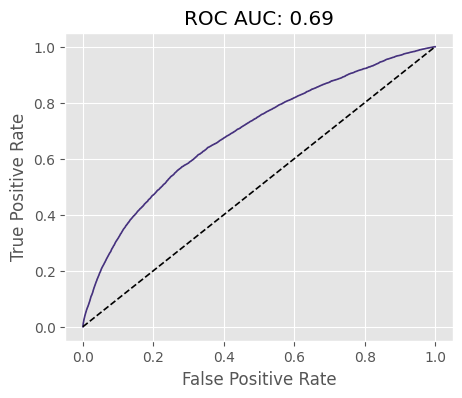

In [ ]:
# Receiver Operating Characteristic Curve - RUC
fpr, tpr, thresholds = roc_curve(y_true = y_test_original,
                                 y_score = y_prob_pred, # Lookup in code above
                                 pos_label = 1)
# RUC
plt.figure(figsize = (5, 4))
sns.set_palette(palette = "viridis") # Viridis pallete
sns.lineplot(data = None,
             x = fpr,
             y = tpr,
             linewidth = 1.2)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC AUC: {auc:.2f}")

# Change level: 0.5
sns.lineplot(data = None,
             x = [0, 1],
             y = [0, 1],
             linewidth = 1.2,
             linestyle = '--',
             color = "black")

"""# Legend
plt.legend(title = 'Tipo NPS',
           loc = 'best',
           bbox_to_anchor=(1, 1))"""

plt.show()

### 2.16 - Feature Importance

In [ ]:
# Feature importance

# Get the feature importance scores from the feature selection step
feature_importances = full_pipeline.named_steps['logisticregression'].feature_importances_

# Final features colnames if removemulticollinearity is apply

# Results feature indices after remove multicollinearity
# mask2 = full_pipeline.named_steps["removemulticollinearity"].feature_indices_

# Results feature indices after select features
# mask3 = [int(i.strip("x")) for i in full_pipeline.named_steps['selectkbest'].get_feature_names_out()]

# Filters
#feature_names = [i[i.find("_") + 2:] for i in full_pipeline.named_steps['columntransformer'].get_feature_names_out()[mask2].tolist()]
# feature_names = [feature_names[i] for i in mask3]

# Because removemulticollinearity isn't apply
feature_names = [i[i.find("_") + 2:] for i in full_pipeline.named_steps['columntransformer'].get_feature_names_out().tolist()]
mask = [int(i.strip("x")) for i in full_pipeline.named_steps['selectkbest'].get_feature_names_out()]
feature_names = [feature_names[i] for i in mask]

# DataFrame
importances_df = pd.DataFrame(data = {"feature": feature_names,
                                      "importance": feature_importances}) \
                   .sort_values(by = "importance", ascending = False) \
                   .query("importance != 0")

# Plot
sns.set_palette(palette = "viridis") # Viridis pallete
plt.subplots(figsize=(5, 7))
sns.barplot(data = importances_df,
            y = "feature",
            x = "importance",
            orient = "h",
            alpha = 0.85,
            palette = sns.color_palette(palette = "viridis", n_colors = len(feature_names)),
            edgecolor = "black")

plt.title("Feature importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

## 3 - Churn prediction: Deep Learning


### 3.0 - Libraries

In [11]:
# Install libraries
%%capture
!pip install tensorflow

In [74]:
# Import libraries
import tensorflow
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall
from tensorflow.random import set_seed
from tensorflow.keras.regularizers import l1, l2

### 3.1 - Data preprocessing pipeline

In [32]:
# Imbalance learn pipelien


# a) Nominal pipeline
nominal_pipeline = make_pipeline(
    # 1. Nominal encoder
    OneHotEncoder(categories = "auto",
                  drop = "first", # "first" or "None", Specifies a methodology to use to drop one of the categories per feature
                  sparse_output = False,
                  dtype = "float", # Desired dtype of output
                  handle_unknown = 'infrequent_if_exist',
                  min_frequency = 0.03,
                  max_categories = 30)
)

# b) Ordinal pipeline
"""
ordinal_pipeline = make_pipeline(
    # 1. Ordinal encoder, if neccesary more steps, aggregate them inside pipeline
    OrdinalEncoder(categories = [["Entre 2 meses y 6 meses", "Entre 7 meses y 1 año", "Entre 1 y 2 años", "Más de 2 años"],
                                 ["De 18 a 25 años", "De 26 a 35 años", "De 36 a 45 años", "De 46 a 55 años", "De 56 a 65 años", "Más de 66"]],
                   dtype = 'float',
                   handle_unknown = 'use_encoded_value',
                   unknown_value = np.nan,
                   encoded_missing_value = np.nan),
)
"""

# c) Categorical transformations
transformations = ColumnTransformer(
    transformers=[("numerical", "passthrough", numerical_vars), # No transformation required for numerical variables
                  # ("ordinal", ordinal_pipeline, ordinal_vars), # No ordinal data
                  ("nominal", nominal_pipeline, nominal_vars)],
    #remainder = 'passthrough'
)


# d) Pipeline to use imbalanced learn function
deep_pipeline = make_pipeline(
    # 1. Numerical and categorical (nominal + ordinal) transformers
    transformations,

    # 2. Impute missing values
    IterativeImputer(estimator = BayesianRidge(),
                     max_iter = 10,
                     random_state = 123456),

    # 3. Scale features
    RobustScaler(with_centering = True,
                 with_scaling = True,
                 quantile_range = (25.0, 75.0),
                 copy = True,
                 unit_variance = False),

    # 4. Transform features
    PowerTransformer(method = 'yeo-johnson',
                     standardize = True,
                     copy = True)
)

deep_pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numerical', 'passthrough',
                                                  ['cant_sem_datos',
                                                   'prom_gb_tt', 'prom_gb_ran',
                                                   'prom_%_propia',
                                                   'continuidad_traf',
                                                   'variacion_datos_8s',
                                                   'cons_ult_sem', 'contrafico',
                                                   'mean_minutos_voz_in',
                                                   'mean_llamadas_in',
                                                   'mean_llamadas_in_num_dif',
                                                   'mean_porcent_llamadas_fallidas_in',
                                                   'mean_porcent_minutos...
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 dtype='float',
                                                                                 handle_unknown='infrequent_if_exist',
                                                                                 max_categories=30,
                                                                                 min_frequency=0.03,
                                                                                 sparse_output=False))]),
                                                  ['canal', 'region', 'bandas',
                                                   'tipo_gross_adds'])])),
                ('iterativeimputer',
                 IterativeImputer(estimator=BayesianRidge(),
                                  random_state=123456)),
                ('robustscaler', RobustScaler()),
                ('powertransformer', PowerTransformer())])

In [21]:
X_train_deep = deep_pipeline.fit_transform(X_train)

In [26]:
X_train_deep.dtype

dtype('float64')

In [22]:
X_test_deep = deep_pipeline.transform(X_test)

### 3.2 - Target variable


In [ ]:
target = to_categorical(y_train)

In [ ]:
target

In [46]:
class_weights = compute_class_weight(class_weight = 'balanced',
                                     classes = np.unique(y_train),
                                     y = y_train.values.reshape(-1))
class_weights = {0: class_weights[0] + 0.29, 1: class_weights[1]}
class_weights

{0: 0.8071377225234297, 1: 15.087702634245188}

### 3.3 - Model

In [78]:
set_seed(123456)

# Predictors: columns
n_cols = X_train_deep.shape[1]

# Model: Specify Architecture
model = Sequential()
model.add(Dense(100, activation = 'relu', input_shape = (n_cols,)))
model.add(Dense(100, activation = 'relu'))
model.add(Dense(100, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

# Compile
model.compile(optimizer = Adam(learning_rate = 0.001),
              loss = 'binary_crossentropy',
              metrics = ['accuracy', Recall()])

In [79]:
# Create a learning rate scheduler callback
lr_scheduler = tensorflow.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch/20)) # traverse a set of learning rate values starting from 1e-4, increasing by 10**(epoch/20) every epoch

In [110]:
# Fitting the model
# Applying backpropagation and gradient descent with your data to update the weights
model.fit(x = X_train_comb,
          y = y_train_comb,
          epochs = 15,
          callbacks = [lr_scheduler],
          batch_size = 32,
          validation_split = 0.2,)
          # class_weight = class_weights)

Epoch 1/15
20068/20068 [==============================] - 66s 3ms/step - loss: 0.2279 - accuracy: 0.9152 - recall_12: 0.9269 - val_loss: 0.2054 - val_accuracy: 0.9299 - val_recall_12: 0.9299 - lr: 1.0000e-04
Epoch 2/15
20068/20068 [==============================] - 64s 3ms/step - loss: 0.1994 - accuracy: 0.9223 - recall_12: 0.9372 - val_loss: 0.2141 - val_accuracy: 0.9251 - val_recall_12: 0.9251 - lr: 1.1220e-04
Epoch 3/15
20068/20068 [==============================] - 61s 3ms/step - loss: 0.1951 - accuracy: 0.9242 - recall_12: 0.9386 - val_loss: 0.1665 - val_accuracy: 0.9474 - val_recall_12: 0.9474 - lr: 1.2589e-04
Epoch 4/15
20068/20068 [==============================] - 61s 3ms/step - loss: 0.1924 - accuracy: 0.9254 - recall_12: 0.9399 - val_loss: 0.1728 - val_accuracy: 0.9430 - val_recall_12: 0.9430 - lr: 1.4125e-04
Epoch 5/15
20068/20068 [==============================] - 66s 3ms/step - loss: 0.1907 - accuracy: 0.9260 - recall_12: 0.9402 - val_loss: 0.1751 - val_accuracy: 0.9420 -

In [94]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_49 (Dense)            (None, 100)               5600      
                                                                 
 dense_50 (Dense)            (None, 100)               10100     
                                                                 
 dense_51 (Dense)            (None, 100)               10100     
                                                                 
 dense_52 (Dense)            (None, 1)                 101       
                                                                 
Total params: 25,901
Trainable params: 25,901
Non-trainable params: 0
_________________________________________________________________


In [104]:
model.evaluate(x = X_test_deep,
               y = y_test)

3723/3723 [==============================] - 8s 2ms/step - loss: 1.5273 - accuracy: 0.9669 - recall_12: 0.0000e+00


[1.5273300409317017, 0.9668605923652649, 0.0]

### 3.4 - Predictions

In [111]:
# Prediction probabilities
y_test_pred_deep = model.predict(X_test_deep)

3723/3723 [==============================] - 7s 2ms/step


In [112]:
predictions = pd.DataFrame(y_test_pred_deep, columns = ['churn_prob']) \
                .assign(churn = y_test) \
                .assign(churn_pred = lambda x: (x['churn_prob'] >= 0.5).astype(int))

In [113]:
predictions.sort_values(by = 'churn_prob', ascending = False)

,churn_prob,churn,churn_pred
46626,9.999989e-01,0,1
2953,9.999986e-01,1,1
104659,9.999968e-01,0,1
109583,9.999956e-01,0,1
52216,9.999956e-01,0,1
...,...,...,...
13131,7.725038e-25,0,0
59904,7.027156e-25,0,0
37826,2.120795e-26,0,0
104347,1.902578e-26,0,0


### 3.5 - Evaluation metrics

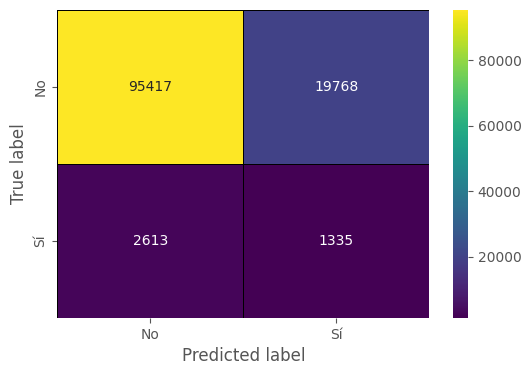

In [114]:
# Confusion matrix
cm = confusion_matrix(y_true = predictions.loc[:, 'churn'],
                      y_pred = predictions.loc[:, 'churn_pred'],
                      #labels = target_encoder.classes_
                      #labels = ["Promotor", "Detractor"]
                      )

plt.figure(figsize=(6, 4))
heatmap = sns.heatmap(cm,
                      annot = True,
                      fmt = 'd',
                      linewidths = 0.5,
                      linecolor='black',
                      cmap = sns.color_palette("viridis", as_cmap = True),
                      xticklabels = ["No", "Sí"],
                      yticklabels = ["No", "Sí"],
                      #xticklabels = target_encoder.classes_,
                      #yticklabels = target_encoder.classes_
                      )

plt.ylabel("True label")
plt.xlabel("Predicted label")

plt.show()

In [115]:
# Classification report
report = classification_report(y_true = predictions.loc[:, 'churn'],
                               y_pred = predictions.loc[:, 'churn_pred'],
                               target_names = ["No", "Sí"])

print(report)

              precision    recall  f1-score   support

          No       0.97      0.83      0.90    115185
          Sí       0.06      0.34      0.11      3948

    accuracy                           0.81    119133
   macro avg       0.52      0.58      0.50    119133
weighted avg       0.94      0.81      0.87    119133



In [116]:
# Metrics for positive class: Detractors
binary_classification_metrics(y_true = predictions.loc[:, 'churn'],
                              y_pred = predictions.loc[:, 'churn_pred'],
                              average = "binary",
                              pos_label = 1)

,Metric,Value
0,Accuracy,0.812
1,Precision,0.063
2,Recall,0.338
3,Specificity,0.828
4,Negative Predictive Value,0.973
5,F1-Score,0.107
6,Balance Accuracy,0.583
7,Jaccard-Score,0.056
8,Matthews Corr Coef,0.078
9,Cohen’s kappa,0.054


In [117]:
# Area under Receiver Operating Characteristic Curve (ROC AUC)

# Probability predictions
y_prob_pred = predictions.loc[:, 'churn_pred']

# Area Under the Receiver Operating Characteristic Curve (ROC AUC)
auc = roc_auc_score(y_true = predictions.loc[:, 'churn'],
                    y_score = y_prob_pred)

print(f"{Fore.BLUE} ROC AUC: {auc:.2f} {Style.RESET_ALL}")

 ROC AUC: 0.58 


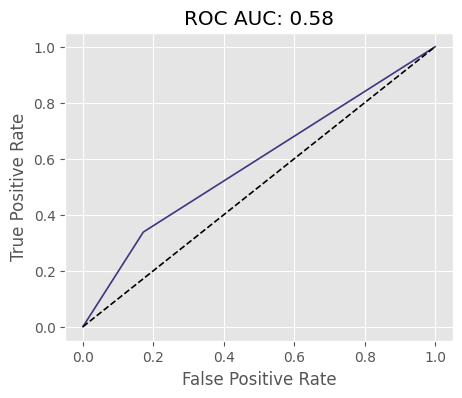

In [118]:
# Receiver Operating Characteristic Curve - RUC
fpr, tpr, thresholds = roc_curve(y_true = predictions.loc[:, 'churn'],
                                 y_score = predictions.loc[:, 'churn_pred'], # Lookup in code above
                                 pos_label = 1)
# RUC
plt.figure(figsize = (5, 4))
sns.set_palette(palette = "viridis") # Viridis pallete
sns.lineplot(data = None,
             x = fpr,
             y = tpr,
             linewidth = 1.2)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC AUC: {auc:.2f}")

# Change level: 0.5
sns.lineplot(data = None,
             x = [0, 1],
             y = [0, 1],
             linewidth = 1.2,
             linestyle = '--',
             color = "black")

"""# Legend
plt.legend(title = 'Tipo NPS',
           loc = 'best',
           bbox_to_anchor=(1, 1))"""

plt.show()